In [27]:
import netket as nk
import numpy as np
from PIL.GimpGradientFile import curved

from scipy.sparse.linalg import eigsh

from tqdm import tqdm
from functools import partial

import jax
import jax.numpy as jnp

from flax import linen as nn # flax is library that brings a more pytorch-like API to JAX
import optax # optax is a library that provides optimizers and learning rate schedules

import matplotlib.pyplot as plt

In [28]:
# defining the hamiltonian on a 4x4 spin lattice

g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

h_nk = nk.operator.Ising(hi, g, h=1.0, J=1.0, dtype=float)
h_nk_sparse = h_nk.to_sparse()
h_jax = h_nk.to_local_operator().to_pauli_strings().to_jax_operator()
h_jax_sparse = h_jax.to_sparse()

print(type(h_nk))
print(type(h_nk_sparse))
print(type(h_jax))
print(type(h_jax_sparse))

<class 'netket.operator._ising.numba.Ising'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'netket.operator._pauli_strings.jax.PauliStringsJax'>
<class 'jax.experimental.sparse.bcsr.BCSR'>


In [30]:
ground_energies, ground_states = eigsh(h_nk_sparse, k=1)
ground_idx = np.argmin(ground_energies)
ground_energy = ground_energies[ground_idx]
ground_state = ground_states[:, ground_idx]

print(f"Ground Energy: {ground_energy:.5f}")

Ground Energy: -34.01060


In [31]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]

        J = self.param("J", nn.initializers.normal(), (n_sites,n_sites), float)

        dtype = jnp.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)

        J_symm = J.T + J
        log_amplitude = jnp.einsum("...i,ij,...j", x, J_symm, x)

        return log_amplitude

In [63]:
# the hamiltonians need to be netket.operator._pauli_strings.jax.PauliStringsJax jax compilation
# the method still works with netket.operator._ising.numba.Ising, but .get_conn_padded() is numba based


def get_local_energies(model, params, h_jax, state_sample_batch):
    conn_states_batch, conn_values_batch = h_jax.get_conn_padded(state_sample_batch)

    log_psi_sample_batch = model.apply(params, state_sample_batch)
    log_psi_conn_batch = model.apply(params, conn_states_batch)

    # for each sample state we have multiple connected states, we need to broadcast log_psi_sample
    log_psi_sample_batch = jnp.expand_dims(log_psi_sample_batch, axis=-1)

    local_energy_batch = jnp.sum(conn_values_batch * jnp.exp(log_psi_conn_batch - log_psi_sample_batch), axis=-1)
    return local_energy_batch


@partial(jax.jit, static_argnames='model')
def estimate_energy_grad(model, params, h_jax, state_sample_batch):
    state_sample_flat = state_sample_batch.reshape(-1, state_sample_batch.shape[-1])
    local_energy_flat = get_local_energies(model, params, h_jax, state_sample_flat)

    energy = jnp.mean(local_energy_flat)

    log_psi_fun = lambda p : model.apply(p, state_sample_flat)
    _, log_psi_vjp = jax.vjp(log_psi_fun, params)

    local_energy_fluctuations = (local_energy_flat - energy) / local_energy_flat.size
    energy_grad = log_psi_vjp(local_energy_fluctuations)[0]

    return energy, energy_grad

In [69]:
class ExpChainLengthSchedule:
    def __init__(self, start: int, end: int, n_steps: int):
        self.start = start
        self.end = end
        self.n_steps = n_steps
        self.log_start = np.log(start)
        self.log_end = np.log(end)

    def get(self, step: int) -> int:
        progress = step / (self.n_steps - 1)
        return int(np.exp(self.log_start + progress * (self.log_end - self.log_start)))

In [70]:
parallel_sample_chains = 40
initial_chain_length = 500
final_chain_length = 5000

episodes = 300
initial_lr = 0.01
lr_decay = 0.6
lr_decay_steps = 50
adamw_weight_decay = 1e-4
adamw_beta1 = 0.6
adamw_beta2 = 0.99

expected_jastrow_factor = 0.02


# initialize the model
model = Jastrow()
key, subkey = jax.random.split(jax.random.PRNGKey(0))
parameters = model.init(key, expected_jastrow_factor * jax.random.normal(subkey, shape=(hi.size,)))

# initialize the learning rate schedule and the optimizer
lr_schedule = optax.exponential_decay(init_value=initial_lr, transition_steps=lr_decay_steps, decay_rate=lr_decay)
optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=adamw_weight_decay, b1=adamw_beta1, b2=adamw_beta2)
opt_state = optimizer.init(parameters)

# initialize the Markov sampler and the chain length schedule
sampler = nk.sampler.MetropolisSampler(hi, nk.sampler.rules.LocalRule(), n_chains=parallel_sample_chains)
sampler_state = sampler.init_state(model, parameters, seed=1)
chain_length_schedule = ExpChainLengthSchedule(initial_chain_length, final_chain_length, episodes)


# training loop
logger = nk.logging.RuntimeLog()
for i in tqdm(range(episodes)):

    # sample states
    chain_length = chain_length_schedule.get(i) // sampler.n_chains
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

    # compute energy and gradient and update parameters
    energy, energy_grad = estimate_energy_grad(model, parameters, h_jax, samples)
    updates, opt_state = optimizer.update(energy_grad, opt_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

    logger(step=i, item={'Energy': energy})

100%|██████████| 300/300 [00:01<00:00, 182.04it/s]


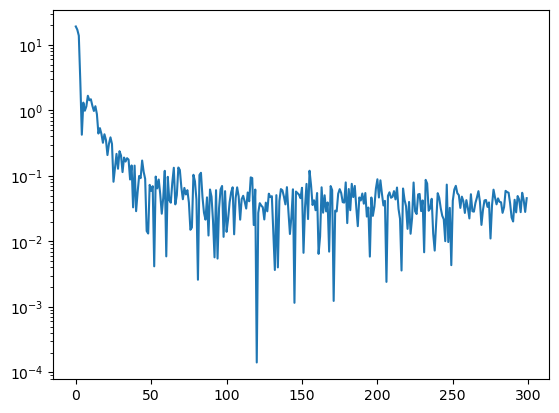

In [71]:
plt.figure()
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()

In [72]:
energy_convergence = np.mean(logger.data['Energy']['value'][-10:])
print(f"Final Energy: {energy_convergence:.5f}")

Final Energy: -33.97223
